In [1]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string, re
import sys, zipfile
from collections import Counter
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Constant
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers import Bidirectional, CuDNNLSTM
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.corpus import names, stopwords, words
from nltk.stem import WordNetLemmatizer
from scipy import stats
from sklearn.metrics import f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
sys.path.insert(0, './code/')
from text_cleaning  import TextClean

%matplotlib inline

glove = "../glove/glove.840B.300d.zip"
embedding_dimension = 300
max_words = 20000
val_split = 0.1

Using TensorFlow backend.


In [2]:
a = TextClean('.', app_name='temple_')

In [3]:
df = pd.read_csv('app_ratings.csv')
df.dropna(subset=['cleaned_text'], how='all', inplace = True)
df_p = df.loc[(df['stars'] > 3) & (df['polsum'] > 0.1)]
df_l = df.loc[(df['stars'] < 3) & (df['polsum'] < 0.1)]

In [4]:
X = list(df_p['cleaned_text']) + list(df_l['cleaned_text'])
y = list(df_p['stars']) + list(df_l['stars'])

In [5]:
X_, y_ = a.even_sample(X, y)

In [6]:
x_a = pd.DataFrame(X_)
x_a['y'] = y_
x_a = x_a.loc[x_a['y']!=3]
x_a['label'] = [1 if x > 3 else 0 for x in list(x_a['y'])]

In [7]:
X_ = list(x_a[0])
y = list(x_a['label'])

In [8]:
sequence_length = max([len(x) for x in X_]) + 1
tokenizer = Tokenizer(num_words=max_words, split=' ', oov_token='<unk>', filters=' ')
tokenizer.fit_on_texts(X_)

X = tokenizer.texts_to_sequences(X_)
X = pad_sequences(X, sequence_length)

In [9]:
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

print("test set size " + str(len(X_test)))

test set size 820


In [10]:
vocab_size = min(max_words, len(tokenizer.word_index)) + 1

def glove(glove_dir, wordindex):      
    embedding_weights = {}
    count_all_words = 0 
    with zipfile.ZipFile(glove_dir) as z:
        with z.open("glove.840B.300d.txt") as f:
            for line in f:
                vals = line.split()
                word = str(vals[0].decode("utf-8")) 
                if word in wordindex:
                    count_all_words+=1
                    coefs = np.asarray(vals[1:], dtype='float32')
                    coefs/=np.linalg.norm(coefs) 
                    embedding_weights[word] = coefs
                if count_all_words==len(wordindex) - 1:
                    break
    return embedding_weights 

embeddings_index = glove("./glove/glove.840B.300d.zip", tokenizer.word_index)

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(300)

In [11]:
model = Sequential([
    Embedding(vocab_size, embedding_dimension, embeddings_initializer=Constant(embedding_matrix),
    input_length=sequence_length,trainable=False),
    SpatialDropout1D(0.5),
    Bidirectional(CuDNNLSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(CuDNNLSTM(64)),
    Dropout(0.5),
    Dense(units=1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2883, 300)         2012700   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 2883, 300)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 2883, 128)         187392    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2883, 128)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               99328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total para

In [12]:
batch_size = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
save_best = ModelCheckpoint('reviews_binary_lstm.hdf', save_best_only=True, 
                           monitor='val_loss', mode='min')
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=batch_size, 
                    callbacks=[early_stopping,save_best],
                    verbose=1, validation_split=0.1)

Train on 6634 samples, validate on 738 samples
Epoch 1/20
6634/6634 [==============================] - 73s 11ms/step - loss: 0.4827 - acc: 0.7641 - val_loss: 0.3295 - val_acc: 0.8753
Epoch 2/20
6634/6634 [==============================] - 69s 10ms/step - loss: 0.4268 - acc: 0.8260 - val_loss: 0.5343 - val_acc: 0.7249
Epoch 3/20
6634/6634 [==============================] - 69s 10ms/step - loss: 0.4203 - acc: 0.8244 - val_loss: 0.3481 - val_acc: 0.8659
Epoch 4/20
6634/6634 [==============================] - 69s 10ms/step - loss: 0.3260 - acc: 0.8788 - val_loss: 0.3367 - val_acc: 0.8686
Epoch 5/20
6634/6634 [==============================] - 69s 10ms/step - loss: 0.3051 - acc: 0.8826 - val_loss: 0.3225 - val_acc: 0.8862
Epoch 6/20
6634/6634 [==============================] - 69s 10ms/step - loss: 0.2919 - acc: 0.8882 - val_loss: 0.3128 - val_acc: 0.8902
Epoch 7/20
6634/6634 [==============================] - 69s 10ms/step - loss: 0.2763 - acc: 0.8922 - val_loss: 0.3080 - val_acc: 0.8848
E

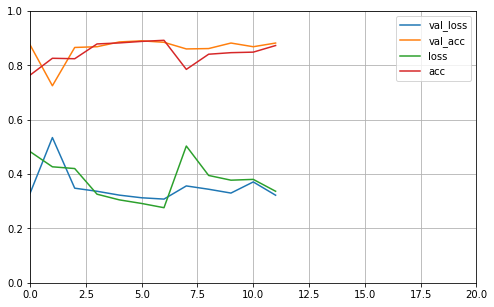

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.axis([0, 20, 0, 1.0])
plt.grid(True)
plt.show()

Text(91.68, 0.5, 'label actual')

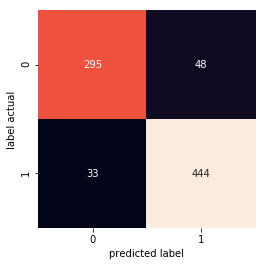

In [14]:
preds = model.predict_classes(X_test)
matrix = confusion_matrix(y_test, preds)

sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0,1],yticklabels=[0,1])

plt.xlabel('predicted label')
plt.ylabel('label actual')

In [15]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       343
           1       0.90      0.93      0.92       477

   micro avg       0.90      0.90      0.90       820
   macro avg       0.90      0.90      0.90       820
weighted avg       0.90      0.90      0.90       820



In [16]:
import pickle

with open('binary_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
info = {
    'tokenizer':'binary_tokenizer.pickle',
    'model':'reviews_binary_lstm.hdf',
    'max_sequence':sequence_length,
    'max_words':max_words,
    'vocab_size':vocab_size
}

import json

with open('binary_project_info.json', 'w') as outfile:
    json.dump(info, outfile)